# 1. Import and Install Dependencies

In [1]:
import cv2
import numpy as np
import os
import mediapipe as mp
import pandas as pd

from matplotlib import pyplot as plt

# 2. Keypoints using MP Hands

importiamo il modello Holistic di MediaPipe

In [2]:
mp_hands = mp.solutions.hands # Hands model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities
mp_drawing_styles = mp.solutions.drawing_styles

funzione di riconoscimento: convertiamo prima l'immagine dal canale BGR (output di OpenCV feed) a quello RGB, necessario per MediaPipe;
alla fine riconvertiamo in BGR

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction with the Holistic model
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

# 3. Extract Keypoint Function

restituisce il numero dei landmark usati per la parte del corpo specificata

Lavoriamo su ciascun landkmark: 

- creiamo degli array dove memorizzare le sue coordinate (dei landmark)

- Useremo degli array di zero quando una certa parte del corpo non è riconosciuta/presente, per non fare andare in errore il sistema.

Facciamo la stessa cosa, ma tutto su una sola linea.

**N.B.** usiamo *flatten()* perchè vogliamo un solo array, unidimensionale, perchè ci servirà questo formato per la LSTM; infatti, senza flatten() avremo una matrice, un array bidimensionale (ciascun landmark avrà *x* valori associati)

come abbiamo detto prima, creiamo un array vuoto (di zeri), per gestire l'errore nel caso in cui una parte del corpo non è riconosciuta.

qui facciamo quello fatto sopra, ma in maniera pù organizzata, in una funzione apposita:

In [4]:
def extract_keypoints_hands(results, hand_landmarks):
    h = np.array([[res.x, res.y, res.z] for res in hand_landmarks.landmark]).flatten() if results.multi_hand_landmarks else np.zeros(21*3)    
    return h

nello specifico:

res.x, res.y, res.z sono i singoli valori delle coord. per ciascun landmark, che verranno inseriti in un array più grande, ciclando per ogni landmark:

- se non esistono coordinate per i landmark, quindi quella parte del corpo non è riconosciuta, viene creato un array vuoto

### abbiamo estratto i **keypoints** per il frame di interesse, che saranno utili per il riconoscimento dei gesti/segni

# 4. Setup and Preprocessing

In [5]:
labels = np.array(["ok", "peace", "rock", "victory", "mano del gaucho", "saluto", "mute", "like", "dislike"])

In [6]:
DATADIR = r"D:\TMS\dataset\hagrid\train"
TESTDIR = r"D:\TMS\dataset\hagrid\test"

creo cartella keypoints

In [7]:
for label in labels:
    label_path = os.path.join(DATADIR, str(label))
    try:
        os.makedirs(os.path.join(label_path, "keypoints"))
    except: pass

elimino frame per cui non sono stati trovati landmark

In [14]:
for label in labels:
    label_path = os.path.join(DATADIR, str(label))
    list_frame = os.listdir(label_path)
    list_frame.remove("keypoints")

    kp_name_list = []

    for kp in os.listdir(os.path.join(label_path, "keypoints")):
        kp_name = kp[0:5]
        kp_name_list.append(kp_name)

    for frame in list_frame:
        frame_path = os.path.join(label_path, frame)

        frame_name = frame[0:5]

        if not frame_name in kp_name_list:
            os.remove(frame_path)

### Resizing

In [32]:
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized

rinomino i frame in modo che abbiano nomi di interi consecutivi

In [15]:
for label in labels:
    label_path = os.path.join(DATADIR, str(label))
    count = 0
    list_frame = os.listdir(label_path)
    list_frame.remove("keypoints")

    for frame in list_frame:
        frame_path = os.path.join(label_path, frame)
        count += 1

        # rinomino i frame in modo che abbiano nomi di interi consecutivi
        new_frame = (str(count)).zfill(5) + ".jpg"
        new_frame_path = os.path.join(label_path, new_frame)
        os.rename(frame_path, new_frame_path)  

In [16]:
for label in labels:
    label_path = os.path.join(DATADIR, str(label))
    count = 0
    print(label)

    kp_path = os.path.join(label_path,"keypoints")
   
    for kp in os.listdir(kp_path):
        kp_path_single = os.path.join(kp_path, kp)
        count += 1

        # rinomino i frame in modo che abbiano nomi di interi consecutivi
        new_name = (str(count)).zfill(5) + ".npy"
        new_kp_path = os.path.join(kp_path, new_name)
        #print(kp_path_single, new_kp_path)
        os.rename(kp_path_single, new_kp_path)  

dislike
like


resize

In [13]:
for label in labels:
    label_path = os.path.join(DATADIR, str(label))
    print(label)
    list_frame = os.listdir(label_path)
    list_frame.remove("keypoints")

    for frame in list_frame:
        frame_path = os.path.join(label_path, frame)
        # resizing & overwriting
        img = cv2.imread(frame_path)  
        #print(frame_path)      
        (w, h) = img.shape[:2]  
        
    
        img_resized = image_resize(img, height = 240)         
        cv2.imwrite(frame_path, img_resized)       

dislike
like


### test

In [7]:
def get_and_append_img(CHAR, path, img):

    img_num = img[0:CHAR] #prendo i primi N char, per non avere l'estensione nel nome quando salvo dopo   
    img_array = cv2.imread(path)  # convert to array               
    return img_array, img_num

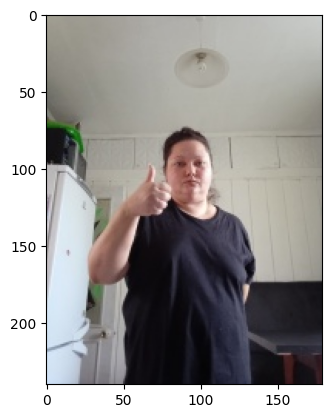

In [11]:
DATADIR2 = r"D:\TMS\dataset\hagrid\train\like"

path_test = os.path.join(DATADIR2, '00001.jpg') 
frame_test = cv2.imread(path_test)  # convert to array
plt.imshow(cv2.cvtColor(frame_test, cv2.COLOR_BGR2RGB)) 

[ 3.14158559e-01  5.09813488e-01 -4.24726636e-08  3.28926712e-01
  4.83181089e-01 -3.25911399e-03  3.59974295e-01  4.56815034e-01
 -9.47548077e-03  3.77923340e-01  4.36351478e-01 -1.61030348e-02
  3.79749835e-01  4.17376161e-01 -2.16388721e-02  3.85962188e-01
  4.64154154e-01 -1.71613321e-02  4.30225044e-01  4.69734609e-01
 -2.96754185e-02  4.30996001e-01  4.73260909e-01 -3.52003612e-02
  4.14996058e-01  4.72082525e-01 -3.66762653e-02  3.85192871e-01
  4.83515859e-01 -2.26957947e-02  4.31238741e-01  4.91412073e-01
 -3.01965959e-02  4.27334487e-01  4.94994074e-01 -2.91769225e-02
  4.11148250e-01  4.93261933e-01 -2.82045063e-02  3.80571991e-01
  5.05101919e-01 -2.83398479e-02  4.23939824e-01  5.13805270e-01
 -3.38395461e-02  4.17208165e-01  5.15239835e-01 -2.78167091e-02
  3.99854541e-01  5.11267781e-01 -2.40501016e-02  3.73282254e-01
  5.26225626e-01 -3.41829136e-02  4.07774985e-01  5.32096446e-01
 -3.72267067e-02  4.00567889e-01  5.32343209e-01 -3.07363365e-02
  3.84249032e-01  5.28114

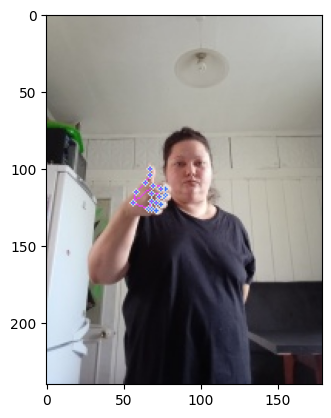

In [12]:
LAST_CHAR = 5

# OTTENGO IL FRAME 
with mp_hands.Hands(max_num_hands = 1, min_detection_confidence=0.5, min_tracking_confidence = 0.5) as hands:   
    
    #img_array, img_num = get_and_append_img(LAST_CHAR, path_test, frame_test)
    image_h, results = mediapipe_detection(frame_test, hands)     
    
    annotated_image = image_h.copy()                  

    first_hand_keypoints = np.zeros(21*3)
    second_hand_keypoints = np.zeros(21*3)

    #TODO aggiustare perchè if lo fa già extract_keypoints
    if results.multi_hand_landmarks:
        
        # num è il numero delle mani che riconosce!! 0 la prima, 1 eventualmente la seconda
        for num, hand_landmarks in enumerate(results.multi_hand_landmarks):   

            mp_drawing.draw_landmarks(     
                annotated_image,
                hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                mp_drawing.DrawingSpec(color=(245,117,66), thickness=1, circle_radius=1),
                mp_drawing.DrawingSpec(color=(245,66,230), thickness=1, circle_radius=1)
                )

            if num == 0: # prima mano riconosciuta 
                first_hand_keypoints = extract_keypoints_hands(results, hand_landmarks)
                #print("\n1st hand shape:", first_hand_keypoints.shape)

            if num == 1: # seconda mano riconosciuta
                second_hand_keypoints = extract_keypoints_hands(results, hand_landmarks)
                #print("\n2nd hand shape:", second_hand_keypoints.shape)

        keypoints = np.concatenate([first_hand_keypoints, second_hand_keypoints])                               

    else:
        print("nessun kp trovato")
        keypoints = np.concatenate([first_hand_keypoints, second_hand_keypoints])

    print(keypoints)    
    plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))     

# 5. Collect Keypoints ...

In [13]:
LAST_CHAR = 5

for label in labels:
    label_path = os.path.join(DATADIR, str(label))
    list_frames = os.listdir(label_path)
    list_frames.remove("keypoints")

    print(label)

    for frame in list_frames:
        frame_path = os.path.join(label_path, frame)

        with mp_hands.Hands(max_num_hands = 1, min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as hands:  
            
            img_array, img_num = get_and_append_img(LAST_CHAR, frame_path, frame)
            image_h, results = mediapipe_detection(img_array, hands)  
            
            first_hand_keypoints = np.zeros(21*3)
            second_hand_keypoints = np.zeros(21*3)

            #TODO aggiustare perchè if lo fa già extract_keypoints
            if results.multi_hand_landmarks:
                
                # num è il numero delle mani che riconosce!! 0 la prima, 1 eventualmente la seconda
                for num, hand_landmarks in enumerate(results.multi_hand_landmarks):              

                    if num == 0: # prima mano riconosciuta 
                        first_hand_keypoints = extract_keypoints_hands(results, hand_landmarks)
                        #print("\n1st hand shape:", first_hand_keypoints.shape)

                    if num == 1: # seconda mano riconosciuta
                        second_hand_keypoints = extract_keypoints_hands(results, hand_landmarks)
                        #print("\n2nd hand shape:", second_hand_keypoints.shape)

                keypoints = np.concatenate([first_hand_keypoints, second_hand_keypoints])
                
                # salvo i keypoints rilevati ed estratti
                npy_path = os.path.join(label_path, "keypoints", img_num)
                np.save(npy_path, keypoints)                               

            #else:
                #print("results:",results.multi_hand_landmarks)
                #print("nessun kp trovato", frame_path, "\n")
                #keypoints = np.concatenate([first_hand_keypoints, second_hand_keypoints])              

dislike
like


# 6. Preprocess Data and Create Labels and Features

In [9]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

In [10]:
labels = np.array(["ok", "peace", "rock", "victory", "mano del gaucho", "saluto", "mute", "like", "dislike"])

In [11]:
label_map = {label:num for num, label in enumerate(labels)}
label_map

{'ok': 0,
 'peace': 1,
 'rock': 2,
 'victory': 3,
 'mano del gaucho': 4,
 'saluto': 5,
 'mute': 6,
 'like': 7,
 'dislike': 8}

inseriamo tutti i keypoints estratti da ciascuna immagine in un array

In [30]:
all_kp = []
labels_list = []


for label in labels:
    label_path = os.path.join(DATADIR, str(label)) 
    kp_path = os.path.join(label_path, "keypoints")
    print(label)

    window = [] 
    
    for kp in os.listdir(kp_path): #range(1, 23130): #prendo i primi 23130 di ogni label, per avere un numero uguale di array-kp
        #kp = (str(kp_num)).zfill(5) + ".npy"
        res = np.load(os.path.join(kp_path, kp))
        window.append(res)      

        labels_list.append(label_map[label])

    all_kp.append(window)    

ok
peace
rock
victory
mano del gaucho
saluto
mute
like
dislike


In [31]:
np.array(labels_list).shape

(208937,)

In [12]:
#all_kp = []
labels_list = []


for label in labels:
    label_path = os.path.join(DATADIR, str(label)) 
    kp_path = os.path.join(label_path, "keypoints")
    print(label)

    #window = [] 
    
    for kp_num in os.listdir(kp_path): #prendo i primi 23130 di ogni label, per avere un numero uguale di array-kp
        #kp = (str(kp_num)).zfill(5) + ".npy"
        #res = np.load(os.path.join(kp_path, kp))
        #window.append(res)      

        labels_list.append(label_map[label])

    #all_kp.append(window)   

ok
peace
rock
victory
mano del gaucho
saluto
mute
like
dislike


In [32]:
np.array(all_kp, dtype=object).shape

(9,)

In [33]:
all_kp_array = np.array(all_kp, dtype=object)

In [34]:
final_array = np.empty((0,126))

for i in range(0, len(labels)):
    final_array = np.concatenate((final_array, all_kp_array[i]))

In [68]:
final_array = np.concatenate([all_kp_array[0],all_kp_array[1],all_kp_array[2],all_kp_array[3],all_kp_array[4],
                              all_kp_array[5],all_kp_array[6],all_kp_array[7],all_kp_array[8]])
final_array.shape

(208937, 126)

In [35]:
print(final_array.shape)

(208937, 126)


In [36]:
X = final_array
X.shape

(208937, 126)

In [13]:
np.array(labels_list).shape

(208937,)

In [14]:
y = np.array(labels_list) 

In [39]:
y.shape

(208937,)

In [15]:
BASEDIR = r"C:\Users\follo\OneDrive\Documenti\GitHub\HGR-4-Social-Robotics"

In [40]:
np.save(os.path.join(BASEDIR, "mytempfiles","X_array"), X)
np.save(os.path.join(BASEDIR, "mytempfiles","y_array"), y)

In [17]:
X = np.load(os.path.join(BASEDIR, "mytempfiles", "X_array.npy"))

In [41]:
X.shape

(208937, 126)

dobbiamo ora splittare l'array dei keypoints, X, e la lista delle label associate a ciascun frame, y, negli insiemi di train e test

splittiamo mantenendo la proporzione:
- 80% train
- 20% test

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=11)

In [19]:
y = to_categorical(labels_list).astype(int)

In [44]:
print("shapes\n")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

shapes

X_train: (167149, 126)
X_test: (41788, 126)
y_train: (167149,)
y_test: (41788,)


avremo così:
- **167'149** immagini di train
- **41'788** immagini di test

# 7. Build and Train ML model / Neural Network

importo dipendendenze

In [10]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, LeaveOneGroupOut

from sklearn.utils import shuffle

In [11]:
# Metriche di valutazione
from sklearn.metrics import ConfusionMatrixDisplay 
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

## Classificazione con modelli ML

Prima della fase di test, per ogni classificatore adotteremo la **stratified k-fold cross validation**, per poter ottenere il miglior modello possibile.
Infatti durante la fase di cross validation i dati del set di training sono splittati in **k** fold, dove ognuna viene usata come set di validation mentre gli altri k-1 come set di training, e il tutto viene ripetuto k volte.

In questo modo è possibile ottimizzare gli **iper-parametri**, migliorando i modelli di classificazione.

Per individuare il modello migliore, è stata utilzzata la funzione **GridSearchCV**, che ci permette di provare diversi iperparametri durante la cross validation e scegliere i più adeguati.

L'utilizzo di una **pipeline** al fine di automatizzare i processi appena descritti è fondamentale per il nostro scopo.

### Random Forest

In [24]:
pipeline = imbpipeline(steps = [['classifier', RandomForestClassifier(max_depth=None, random_state=None)]]) 

In [25]:
stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=12)

Notiamo che per il parametro estimator, ossia come modello, nella GridSearchCV è stata passata proprio una pipeline.

In [26]:
# in param_grid sono definiti gli iperparametri
param_grid = {
                'n_estimators': [50, 100, 200],
                'max_depth': [4, 6, 10, 12],
                }

new_params = {'classifier__' + key: param_grid[key] for key in param_grid}

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=new_params,
                           scoring='accuracy',
                           cv=stratified_kfold,
                           verbose = 5,
                           n_jobs=-1) # utilizzerà tutti i processori disponibili

In [27]:
# troviamo il modello migliore
grid_search.fit(X_train, y_train)

cv_score = grid_search.best_score_
best_params = grid_search.best_params_

print(f'Best parameters: {best_params}')
print(f'Cross-validation score: {cv_score}')

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters: {'classifier__max_depth': 12, 'classifier__n_estimators': 200}
Cross-validation score: 0.9014412205574066


In [28]:
y_test_predict = grid_search.predict(X_test)

In [29]:
y_test_predict_prob=grid_search.predict_proba(X_test)

accuracy: 0.9050445103857567
precision: 0.9056638041440951
recall: 0.8995167460784805
f1: 0.9016362404694226


[]

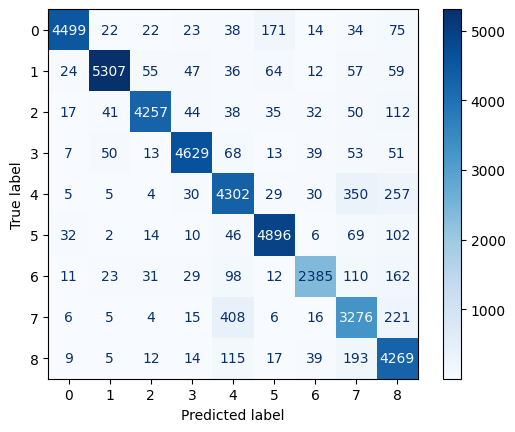

In [30]:
# calcoliamo le metriche di valutazione
accuracy = accuracy_score(y_test, y_test_predict)
precision = precision_score(y_test, y_test_predict, average='macro')
recall = recall_score(y_test, y_test_predict, average='macro')
f1 = f1_score(y_test, y_test_predict, average='macro')

ConfusionMatrixDisplay.from_predictions(y_test, 
                                        y_test_predict, 
                                        cmap=plt.cm.Blues)

print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {f1}')


plt.plot()

### SVM

proviamo prima ad addestrare la SVM con degli iperparametri *casuali*

In [46]:
model_svm = SVC(C= 10, gamma = 0.01, kernel = 'rbf', probability=True) # iperparametri migliori per cecca

In [47]:
model_svm.fit(X_train, y_train)
y_test_predict = model_svm.predict(X_test)

accuracy: 0.9114817651000288
precision: 0.9175232288278923
recall: 0.9043598901495253
f1: 0.9082056033906666


[]

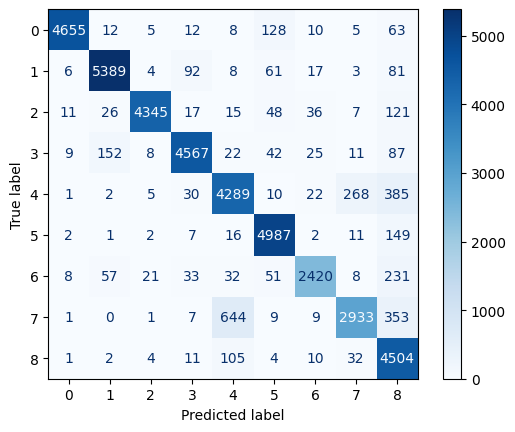

In [114]:
# calcoliamo le metriche di valutazione
accuracy = accuracy_score(y_test, y_test_predict)
precision = precision_score(y_test, y_test_predict, average='macro')
recall = recall_score(y_test, y_test_predict, average='macro')
f1 = f1_score(y_test, y_test_predict, average='macro')

ConfusionMatrixDisplay.from_predictions(y_test, 
                                        y_test_predict, 
                                        cmap=plt.cm.Blues)

print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {f1}')


plt.plot()

potremmo trovare gli iperparametri migliori grazie alla pipeline e alla grid-search, ma ciò risulterebbe impraticabile perchè l'algoritmo della classe SVC (per creare SVM) ha complessità **quadratica**, quindi O(n^2).

salvo modello

In [115]:
import pickle

In [20]:
filename_svm = r"C:\Users\follo\OneDrive\Documenti\GitHub\HGR-4-Social-Robotics\models_action\my_model_svm.pickle"

In [117]:
pickle.dump(model_svm, open(filename_svm, "wb"))

### Gradient Boost

In [93]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler

In [94]:
pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                                ['scaler', MinMaxScaler()],
                                ['classifier',GradientBoostingClassifier(n_estimators=100,
                                                                         learning_rate=1.0,
                                                                         max_depth=1, 
                                                                         random_state=11)]]) #decidete se mettere qualche parametro

In [95]:
stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=12)

In [96]:
# in param_grid sono definiti gli iperparametri
param_grid = {   
              'max_depth': range (2, 10, 1),
              'n_estimators': range(60, 220, 40),
              'learning_rate': [0.1, 0.01, 0.05]
              }

new_params = {'classifier__' + key: param_grid[key] for key in param_grid}

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=new_params,
                           scoring='accuracy',
                           cv=stratified_kfold,
                           verbose = 5,
                           n_jobs=-1) # utilizzerà tutti i processori disponibili

In [97]:
# troviamo il modello migliore
grid_search.fit(X_train, y_train)

cv_score = grid_search.best_score_
best_params = grid_search.best_params_

print(f'Best parameters: {best_params}')
print(f'Cross-validation score: {cv_score}')

# effetuamo la predizione sul set di test
y_test_predict = grid_search.predict(X_test)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


## Classificazione con modelli di Deep Learning ?????

# 8. DETECT from a single image

funzione che associa una probabilità alla prediction del gesto eseguito

In [20]:
colors = [(245,117,16), (117,245,16), (16,117,245), (56,125,200), (88,22,152), (50,180,255), (99,22,255), (100,90,87), (64,180,120)]

def prob_viz(res, jester_gestures, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0, 60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, jester_gestures[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

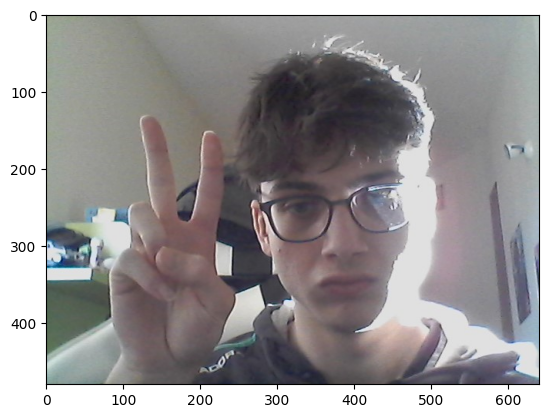

In [16]:
IMGDIR = r"C:\Users\follo\OneDrive\Desktop\peace.jpg"

image = cv2.imread(IMGDIR)
#image_resized = image_resize(image, height = 240)  
image_flipped = cv2.flip(image, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)) 

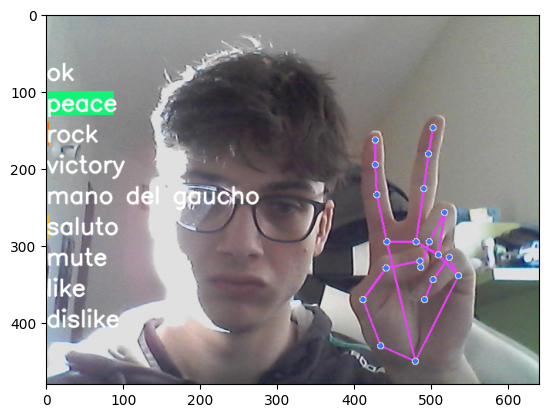

In [19]:
LAST_CHAR = 5

# OTTENGO IL FRAME 
with mp_hands.Hands(max_num_hands = 1, min_detection_confidence=0.5, min_tracking_confidence = 0.5) as hands:   
    
    image_h, results = mediapipe_detection(image_flipped, hands)     
    
    annotated_image = image_h.copy()                  

    first_hand_keypoints = np.zeros(21*3)
    second_hand_keypoints = np.zeros(21*3)

    #TODO aggiustare perchè if lo fa già extract_keypoints
    if results.multi_hand_landmarks:
        
        # num è il numero delle mani che riconosce!! 0 la prima, 1 eventualmente la seconda
        for num, hand_landmarks in enumerate(results.multi_hand_landmarks):   

            mp_drawing.draw_landmarks(     
                annotated_image,
                hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2),
                mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                )

            if num == 0: # prima mano riconosciuta 
                first_hand_keypoints = extract_keypoints_hands(results, hand_landmarks)
                #print("\n1st hand shape:", first_hand_keypoints.shape)

            if num == 1: # seconda mano riconosciuta
                second_hand_keypoints = extract_keypoints_hands(results, hand_landmarks)
                #print("\n2nd hand shape:", second_hand_keypoints.shape)

        keypoints = np.concatenate([first_hand_keypoints, second_hand_keypoints])                               

    else:
        print("nessun kp trovato")
        keypoints = np.concatenate([first_hand_keypoints, second_hand_keypoints])

    # associamo probabilità e visualizziamo graficamente
    image_prob = prob_viz(res[0], labels, annotated_image, colors)
    plt.imshow(cv2.cvtColor(image_prob, cv2.COLOR_BGR2RGB))  

Nell'immagine di sopra possiamo vedere come per il **gesto** performato nel frame, in cui è stata riconosciuta correttamente la mano e sono ben visibili i **21 landmarks** 3D, è associata, nella parte sx dell'immagine, una **barra** colorata per ogni label presente. Questa barra rappresenta la probabilità che il gesto performato corrisponda alla label ad essa associata.

La **prediction** finale, restituita in output, rappresenterà la label del gesto a cui è associata la probabilità **maggiore**, e dunque quella avente la barra più lunga.

In questo caso, la barra più grande è quella associata alla label *peace*, che sarà dunque la **prediction** del modello per il gesto di questo frame, e sarà tra l'altro corretta.

In [18]:
res = grid_search.predict_proba([keypoints])
print("all prob:", res)
print("idx:", np.argmax(res))
print("prediction:", labels[np.argmax(res)])
print("prob:", res[0][np.argmax(res)])

all prob: [[0.00852878 0.87401173 0.0334133  0.01424194 0.00363431 0.04397191
  0.00798147 0.00601771 0.00819885]]
idx: 1
prediction: peace
prob: 0.8740117301197451


In [22]:
res = model_svm.predict_proba([keypoints])

AttributeError: predict_proba is not available when  probability=False

Abbiamo ora visto come ad ogni gesto è associata una **probabilità**, questa volta in formato **numerico**:
- ricordiamo che la **prediction** restituita in output rappresenterà la label del gesto a cui è associata la probabilità **maggiore**.

# 9. Save Weights

salvo modello Random Forest

In [21]:
import pickle

In [22]:
filename_rndf = r"C:\Users\follo\OneDrive\Documenti\GitHub\HGR-4-Social-Robotics\models_action\my_model_rndf.pickle"

In [45]:
# save model
model_rndf = grid_search.best_estimator_
pickle.dump(model_rndf, open(filename_rndf, "wb"))

In [23]:
# load model
grid_search = pickle.load(open(filename_rndf, 'rb'))

In [21]:
model_svm = pickle.load(open(filename_svm, 'rb'))

# 10. Test in Real Time

In [24]:
# 1. New detection variables
sequence = []
predictions = []
gesto = ""
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_hands.Hands(max_num_hands=2, min_detection_confidence=0.5) as hands:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()
        frame = cv2.flip(frame, 1) # specchiamo il frame

        if not ret:
            print("Ignoring empty camera frame.")
            # If loading a video, use 'break' instead of 'continue'.
            continue
        
        # Make detections
        image, results = mediapipe_detection(frame, hands)
        print(results)        
        print("which hand?", results.multi_handedness)

        first_hand_keypoints = np.zeros(21*3)
        second_hand_keypoints = np.zeros(21*3)
    
        if results.multi_hand_landmarks:
            for num, hand_landmarks in enumerate(results.multi_hand_landmarks):        

                mp_drawing.draw_landmarks(     
                    image,
                    hand_landmarks,
                    mp_hands.HAND_CONNECTIONS,
                    mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2),
                    mp_drawing.DrawingSpec(color=(200,66,230), thickness=2, circle_radius=2)
                    )
                
                if num == 0:   
                    first_hand_keypoints = extract_keypoints_hands(results, hand_landmarks)
                    #print("\n1st hand kp:", first_hand_keypoints_test)
                if num == 1:
                    second_hand_keypoints = extract_keypoints_hands(results, hand_landmarks)
                    #print("\n2nd hand kp:", second_hand_keypoints_test)

            keypoints = np.concatenate([first_hand_keypoints, second_hand_keypoints])    

        else: 
            keypoints = np.zeros(21*6)
            print("no detect")
                        
        # 2. Prediction logic
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = grid_search.predict_proba([keypoints])
            res = res[0] # è contenuto in un array | TODO togliere
            print(labels[np.argmax(res)])
            predictions.append(np.argmax(res))
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold:                     
                    gesto = labels[np.argmax(res)]
             
            # Viz probabilities
            image = prob_viz(res, labels, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(gesto), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
which hand? None
no detect
<class 'mediapipe.python.solution_base.SolutionOutputs'>
which hand? None
no detect
<class 'mediapipe.python.solution_base.SolutionOutputs'>
which hand? None
no detect
<class 'mediapipe.python.solution_base.SolutionOutputs'>
which hand? None
no detect
<class 'mediapipe.python.solution_base.SolutionOutputs'>
which hand? None
no detect
<class 'mediapipe.python.solution_base.SolutionOutputs'>
which hand? [classification {
  index: 1
  score: 0.9921078085899353
  label: "Right"
}
]
<class 'mediapipe.python.solution_base.SolutionOutputs'>
which hand? None
no detect
<class 'mediapipe.python.solution_base.SolutionOutputs'>
which hand? None
no detect
<class 'mediapipe.python.solution_base.SolutionOutputs'>
which hand? [classification {
  index: 1
  score: 0.996165931224823
  label: "Right"
}
]
<class 'mediapipe.python.solution_base.SolutionOutputs'>
which hand? None
no detect
<class 'mediapipe.python.solution_b